In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys
import random
import seaborn as sns
from matplotlib.font_manager import FontProperties
font1 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=14)
font2 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=12)
font3 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=10)
font4 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=7)
sns.set_style('whitegrid')
sns.set_palette("muted")
random.seed(20241120)
np.random.seed(20241120)
torch.manual_seed(3407) # Torch.manual_seed(3407) is all you need. Paper: http://arxiv.org/abs/2109.08203
# 修改工作路径，使本.ipynb文件能够像在本文件夹根目录下一样导入其他模块
# Modify the working path so that this.ipynb file can import other modules like in the root directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(current_dir, '..'))

In [11]:
df_whole=pd.read_excel("E:\\科创优才\\实验数据\\天然气锅炉数据1.xlsx", sheet_name="稳定运行数据段")
units=df_whole.iloc[0].tolist()
df=df_whole.iloc[2:].reset_index(drop=True)

# 重命名所有列名，缩短名称长度，方便使用
df.columns=[
    '开始时间',
    '主蒸汽流量计算值',
    '烟气含氧量（CEMS）',
    '颗粒浓度',
    '二氧化硫',
    'NO浓度',
    'NO2浓度',
    'NOX标干浓度',
    'NOX浓度',
    '烟气湿度（CEMS）',
    '烟气压力（CEMS）',
    '烟气温度（CEMS）',
    '一氧化碳',
    '锅炉天然气进气流量',
    '锅炉天然气进气温度',
    '锅炉天然气进气压力',
    '鼓风机出口温度',
    '鼓风机出口压力',
    '鼓风机变频器输出反馈',
    '鼓风机变频器电流反馈',
    '再循环烟气调节阀反馈',
    '冷凝器出口烟气调节阀反馈',
    '炉膛出口烟气温度（B分度）',
    '炉膛出口烟气压力',
    'SWY大气压',
    'SWY天气温度',
    'SWY空气湿度',
    'SWY湿球温度',
    '主蒸汽温度(蒸汽集箱出口温度）',
    '主蒸汽压力(蒸汽集箱出口压力）',
    '分汽缸温度',
    '分汽缸压力',
    '分汽缸出口至DN400蒸汽温度',
    '过热器集箱出口蒸汽温度',
    '天然气累计流量',
    '冷凝器烟气流量（累计值）',
    '冷凝器出口烟气流量',
    '冷凝器出口烟气温度'
]

# 将可能用到的变量名和单位存入字典
var_dict={
    "主蒸汽流量计算值": "t/h",
    "烟气含氧量（CEMS）": "mg/Nm3",
    "NO浓度": "mg/Nm3",
    "NO2浓度": "mg/Nm3",
    "NOX浓度": "mg/Nm3",
    "烟气湿度（CEMS）": "%",
    "烟气压力（CEMS）": "Pa",
    "烟气温度（CEMS）": "℃",
    "一氧化碳": "mg/Nm3",
    "锅炉天然气进气流量": "m3/h",
    "锅炉天然气进气温度": "℃",
    "锅炉天然气进气压力": "kPa",
    '鼓风机出口温度': "℃",
    "鼓风机出口压力": "kPa",
    "鼓风机变频器输出反馈": "Hz",
    "鼓风机变频器电流反馈": "A",
    "冷凝器出口烟气调节阀反馈": "%",
    "炉膛出口烟气压力": "Pa",
    "SWY大气压": "kPa",
    "SWY天气温度": "℃",
    "SWY空气湿度": "%",
    'SWY湿球温度': "℃",
    '主蒸汽温度(蒸汽集箱出口温度）': "℃",
    "主蒸汽压力(蒸汽集箱出口压力）": "MPa",
    "分汽缸温度": "℃",
    "分汽缸压力": "MPa",
    '分汽缸出口至DN400蒸汽温度': "℃",
    '过热器集箱出口蒸汽温度': "℃",
    "冷凝器出口烟气流量": "Nm3/h",
    "冷凝器出口烟气温度": "℃",
}

# 定义输入变量
input_var_names=[
    "主蒸汽流量计算值",
    "锅炉天然气进气流量",
    "锅炉天然气进气温度",
    "锅炉天然气进气压力",
    '鼓风机出口温度',
    "鼓风机出口压力",
    "鼓风机变频器输出反馈",
    "鼓风机变频器电流反馈",
    "冷凝器出口烟气调节阀反馈",
    "SWY大气压",
    "SWY天气温度",
    "SWY空气湿度",
    'SWY湿球温度',
    "主蒸汽温度(蒸汽集箱出口温度）",
    "主蒸汽压力(蒸汽集箱出口压力）",
]

# 定义输出变量
output_var_names=[
    "烟气含氧量（CEMS）",
    "NO浓度",
    #"NO2浓度", # 主要预测NO，因为NO2的准确性有待考量
    #"NOX浓度",
    "烟气湿度（CEMS）",
    "烟气压力（CEMS）",
    "烟气温度（CEMS）",
    "一氧化碳",
    "炉膛出口烟气压力",

    #暂时不考虑以下输出变量
    #"分汽缸温度",
    #"分汽缸压力",
    #"分汽缸出口至DN400蒸汽温度",
    #"过热器集箱出口蒸汽温度",
    #"冷凝器出口烟气流量",
    #"冷凝器出口烟气温度",
]

input_var_dict={name:var_dict[name] for name in input_var_names}
output_var_dict={name:var_dict[name] for name in output_var_names}

var_names=list(var_dict.keys())
var_units=list(var_dict.values())
input_var_indices=[var_names.index(name) for name in input_var_names]
output_var_indices=[var_names.index(name) for name in output_var_names]


data_np=df[var_names].to_numpy(dtype=float)

# 通过不同切片增加数据量
DATA=[
    data_np,
    data_np[:20,:],
    data_np[:50,:],
    data_np[:100,:],
    data_np[:800,:],
    data_np[100:850,:],
    data_np[200:900,:],
    data_np[300:950,:],
    data_np[400:1000,:],
    ]
print("data_np.shape:", data_np.shape)

data_np.shape: (1124, 30)


In [3]:
from gas_data_prediction.data_preprocessing import time_series_standardization, time_series_split, train_test_split

input_len=10
output_len=1
input_channels=len(var_names)
output_channels=len(var_names)

DATA, var_mean , var_std_dev = time_series_standardization(data=DATA, mode="multiple") # list of numpy arrays of shape (n_timesteps, n_vars)
X, Y, X_grouped, Y_grouped = time_series_split(data=DATA,
                                                input_len=input_len,
                                                output_len=output_len,
                                                input_indices=input_var_indices,
                                                output_indices=output_var_indices,
                                                mode="multiple")

(train_indices, test_indices),\
    (X_train, Y_train, X_train_grouped, Y_train_grouped), \
    (X_test, Y_test, X_test_grouped, Y_test_grouped) \
        = train_test_split(X_grouped, Y_grouped, train_ratio=0.8, test_ratio=0.2)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("\n")
print("len(X_train_grouped):", len(X_train_grouped))
print("len(Y_train_grouped):", len(Y_train_grouped))
print("X_train_grouped[0] shape:", X_train_grouped[0].shape)
print("Y_train_grouped[0] shape:", Y_train_grouped[0].shape)
print("\n")
print("len(X_test_grouped):", len(X_test_grouped))
print("len(Y_test_grouped):", len(Y_test_grouped))
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)
print("X_test_grouped[0] shape:", X_test_grouped[0].shape)
print("Y_test_grouped[0] shape:", Y_test_grouped[0].shape)
print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("len(X_grouped):", len(X_grouped))
print("len(Y_grouped):", len(Y_grouped))
print("X_grouped[0] shape:", X_grouped[0].shape)
print("Y_grouped[0] shape:", Y_grouped[0].shape)

train_indices: [2, 8, 1, 7, 3, 4, 0]
test_indices: [5, 6]
num_train: 7
num_test: 2
X_train shape: (3274, 10, 15)
Y_train shape: (3274, 1, 7)


len(X_train_grouped): 7
len(Y_train_grouped): 7
X_train_grouped[0] shape: (40, 10, 15)
Y_train_grouped[0] shape: (40, 1, 7)


len(X_test_grouped): 2
len(Y_test_grouped): 2
X_test shape: (1430, 10, 15)
Y_test shape: (1430, 1, 7)
X_test_grouped[0] shape: (740, 10, 15)
Y_test_grouped[0] shape: (740, 1, 7)
X shape: (4704, 10, 15)
Y shape: (4704, 1, 7)
len(X_grouped): 9
len(Y_grouped): 9
X_grouped[0] shape: (1114, 10, 15)
Y_grouped[0] shape: (1114, 1, 7)


In [4]:
from models.RNN import RNN, LSTM, GRU
from models.CNN import CNN, TCN
from models.MLP import MLP
from models.transformer import Transformer, iTransformer, PatchTST, Reformer, Informer
from models.Linear import LLinear, DLinear, NLinear
from models.stat import Identical, ExponentialMovingAverage, SVR
from gas_data_prediction.utils import FitHistory

# Hyperparameters
num_epochs = 20
learning_rate = 0.001
input_len = 10
output_len = 1
label_len = 0 # label_len should be set only for decoder-based models, or there is potential risk of data leakage.
input_channels = 15
output_channels = 7
batch_size = 32
#device = 'cpu'  # 设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Instantiate models, loss functions, evaluation functions, and optimizers
# 实例化模型、损失函数、评估函数和优化器
MODEL = LSTM(
    input_len=input_len, output_len=output_len, input_channels=input_channels, output_channels=output_channels,
    ).to(device)
loss_func = nn.MSELoss()
metric_func=nn.L1Loss()
optimizer = optim.Adam(MODEL.parameters(), lr=learning_rate)
history=FitHistory()
print('Model parameters: ', sum(p.numel() for p in MODEL.parameters()))

Model parameters:  7591


In [5]:
from gas_data_prediction.data_preprocessing import get_XY_loaders
train_loader, val_loader, test_loader = get_XY_loaders(X_train, Y_train, batch_size=batch_size)

Train dataset size: X: (2291, 10, 15); Y: (2291, 1, 7)
Val dataset size: X: (327, 10, 15); Y: (327, 1, 7)
Test dataset size: X: (654, 10, 15); Y: (654, 1, 7)


  5%|▌         | 1/20 [00:00<00:08,  2.25it/s]

Epoch [ 1  /20], Time: 0.4453s, Loss: 0.8491, Metric: 0.6144, Val Loss: 0.5459, Val Metric: 0.4953


 10%|█         | 2/20 [00:00<00:06,  2.93it/s]

Epoch [ 2  /20], Time: 0.2622s, Loss: 0.6894, Metric: 0.5033, Val Loss: 0.5027, Val Metric: 0.4698


 15%|█▌        | 3/20 [00:00<00:05,  3.24it/s]

Epoch [ 3  /20], Time: 0.2653s, Loss: 0.6384, Metric: 0.4731, Val Loss: 0.4460, Val Metric: 0.4248


 20%|██        | 4/20 [00:01<00:04,  3.44it/s]

Epoch [ 4  /20], Time: 0.2611s, Loss: 0.5707, Metric: 0.4387, Val Loss: 0.3890, Val Metric: 0.3850


 25%|██▌       | 5/20 [00:01<00:04,  3.52it/s]

Epoch [ 5  /20], Time: 0.2670s, Loss: 0.5262, Metric: 0.4107, Val Loss: 0.3768, Val Metric: 0.3796


 30%|███       | 6/20 [00:01<00:03,  3.53it/s]

Epoch [ 6  /20], Time: 0.2820s, Loss: 0.4924, Metric: 0.3927, Val Loss: 0.3615, Val Metric: 0.3683


 35%|███▌      | 7/20 [00:02<00:03,  3.56it/s]

Epoch [ 7  /20], Time: 0.2729s, Loss: 0.4623, Metric: 0.3783, Val Loss: 0.3303, Val Metric: 0.3451


 40%|████      | 8/20 [00:02<00:03,  3.56it/s]

Epoch [ 8  /20], Time: 0.2810s, Loss: 0.4378, Metric: 0.3604, Val Loss: 0.3217, Val Metric: 0.3383


 45%|████▌     | 9/20 [00:02<00:03,  3.57it/s]

Epoch [ 9  /20], Time: 0.2773s, Loss: 0.4176, Metric: 0.3509, Val Loss: 0.3112, Val Metric: 0.3265


 50%|█████     | 10/20 [00:02<00:02,  3.60it/s]

Epoch [ 10 /20], Time: 0.2674s, Loss: 0.4000, Metric: 0.3367, Val Loss: 0.3196, Val Metric: 0.3395


 55%|█████▌    | 11/20 [00:03<00:02,  3.62it/s]

Epoch [ 11 /20], Time: 0.2731s, Loss: 0.3872, Metric: 0.3329, Val Loss: 0.3077, Val Metric: 0.3377


 60%|██████    | 12/20 [00:03<00:02,  3.62it/s]

Epoch [ 12 /20], Time: 0.2766s, Loss: 0.3701, Metric: 0.3257, Val Loss: 0.5137, Val Metric: 0.3444


 65%|██████▌   | 13/20 [00:03<00:01,  3.62it/s]

Epoch [ 13 /20], Time: 0.2754s, Loss: 0.3607, Metric: 0.3204, Val Loss: 0.2855, Val Metric: 0.3161


 70%|███████   | 14/20 [00:03<00:01,  3.68it/s]

Epoch [ 14 /20], Time: 0.2612s, Loss: 0.3445, Metric: 0.3136, Val Loss: 0.2861, Val Metric: 0.3177


 75%|███████▌  | 15/20 [00:04<00:01,  3.70it/s]

Epoch [ 15 /20], Time: 0.2680s, Loss: 0.3396, Metric: 0.3124, Val Loss: 0.2629, Val Metric: 0.2992


 80%|████████  | 16/20 [00:04<00:01,  3.69it/s]

Epoch [ 16 /20], Time: 0.2676s, Loss: 0.3357, Metric: 0.3098, Val Loss: 0.2774, Val Metric: 0.3140


 85%|████████▌ | 17/20 [00:04<00:00,  3.72it/s]

Epoch [ 17 /20], Time: 0.2642s, Loss: 0.3249, Metric: 0.3067, Val Loss: 0.2606, Val Metric: 0.3023


 90%|█████████ | 18/20 [00:05<00:00,  3.69it/s]

Epoch [ 18 /20], Time: 0.2745s, Loss: 0.3192, Metric: 0.3035, Val Loss: 0.2614, Val Metric: 0.3130


 95%|█████████▌| 19/20 [00:05<00:00,  3.66it/s]

Epoch [ 19 /20], Time: 0.2792s, Loss: 0.3025, Metric: 0.2985, Val Loss: 0.2586, Val Metric: 0.2959


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]

Epoch [ 20 /20], Time: 0.2670s, Loss: 0.3120, Metric: 0.3008, Val Loss: 0.2471, Val Metric: 0.2895
Total Time: 5.5885s


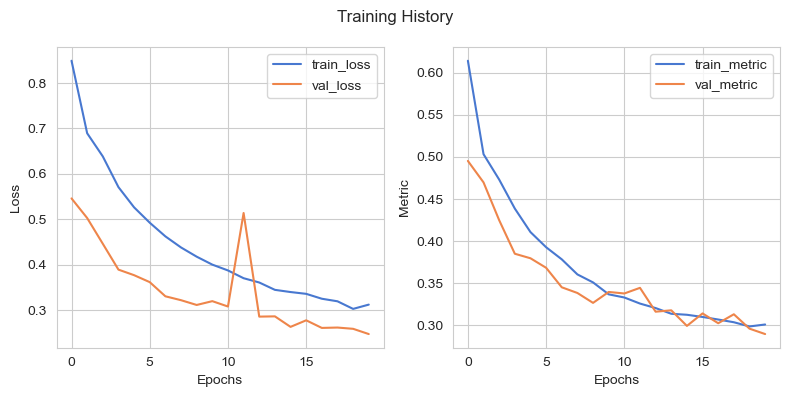

Number of epochs:  20
Training time:     5.5885s
Training loss:     0.3120
Training metric:   0.3008
Validation loss:   0.2471
Validation metric: 0.2895
Loss on test set:  0.3081173300743103


In [6]:
from gas_data_prediction.utils import train
# train the model
history.update(
            *train(MODEL, train_loader, val_loader, optimizer,
                loss_func=nn.MSELoss(),
                metric_func=nn.L1Loss(),
                num_epochs=num_epochs,
                device=device,
                verbose=1)
            )
history.plot()
history.summary()
print("Loss on test set: ", MODEL.evaluate((X_test, Y_test),mode="numpy",device=device))


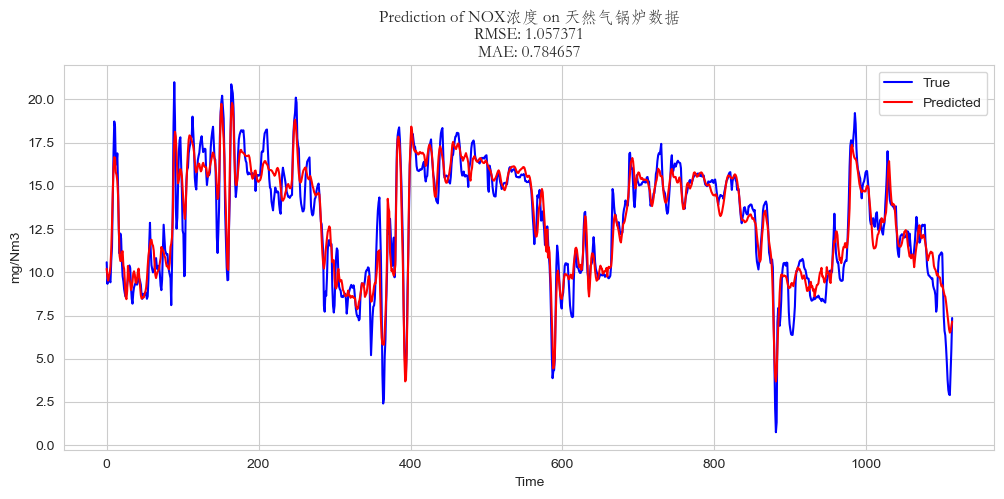

In [7]:
# Visualize on a particular variable and particular file
from gas_data_prediction.utils import visualize_var, get_pred_true_pairs, get_pred_true_pairs_with_Tensor

var_idx=4
data_idx=0

Y_pred, Y_true=get_pred_true_pairs_with_Tensor(MODEL,X_grouped[data_idx],Y_grouped[data_idx])

shared_params={
    'Y_pred': Y_pred,
    'Y_true': Y_true,
    'var_idx': var_idx,
    'var_names': var_names,
    'var_units': var_units,
    'data_name': "天然气锅炉数据",
    'var_mean': var_mean,
    'var_std_dev': var_std_dev,
}


visualize_var(**shared_params, plot_residual=0, rescale=1)

In [12]:
var_prediction_info={}
for var_idx, (var_name, var_unit) in enumerate(output_var_dict.items()):
    Y_pred, Y_true=get_pred_true_pairs_with_Tensor(MODEL,X_test_grouped[data_idx],Y_test_grouped[data_idx])
    y_true=Y_true[:,var_idx] # shape: (n_samples,)
    y_pred=Y_pred[:,var_idx] # shape: (n_samples,)
    y_mean=var_mean[var_idx] # float
    y_std_dev=var_std_dev[var_idx] # float

    RMSE=np.sqrt(((y_true-y_pred)**2).mean())
    MAE=np.abs(y_true-y_pred).mean()
    RMSE_rescaled=RMSE*var_std_dev[var_idx]
    MAE_rescaled=MAE*var_std_dev[var_idx]
    var_prediction_info[var_name]=[var_unit, RMSE,RMSE_rescaled,MAE,MAE_rescaled]

df=pd.DataFrame(var_prediction_info,index=['unit', 'RMSE','RMSE_rescaled','MAE','MAE_rescaled']).T
#df.to_csv('20241120_NN_prediction_info.csv')
df

,unit,RMSE,RMSE_rescaled,MAE,MAE_rescaled
烟气含氧量（CEMS）,mg/Nm3,0.58605,3.081306,0.26272,1.381318
NO浓度,mg/Nm3,0.484116,0.544072,0.283891,0.319051
烟气湿度（CEMS）,%,0.490225,1.361343,0.314518,0.873409
烟气压力（CEMS）,Pa,0.767361,1.525666,0.518938,1.031752
烟气温度（CEMS）,℃,0.294365,0.971146,0.216083,0.712883
一氧化碳,mg/Nm3,0.695451,0.561837,0.207178,0.167374
炉膛出口烟气压力,Pa,0.338782,2.199359,0.241448,1.567471
